<a href="https://colab.research.google.com/github/Blvisse/Pharmtec_Sales/blob/dashboard/PharmtechAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import logging 
from fbprophet import Prophet

logging.basicConfig(filename='notebook.log', filemode='w', format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',level=logging.DEBUG)



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mount drive to access remote dvc data

In [2]:
logging.debug(" ----- Mounting Drive ------")
logging.info(" ------  Accessing data to Drive ------")

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/phamtech_data

/content/drive/MyDrive/phamtech_data


In [37]:
# !pip install dvc

In [165]:
logging.debug(" ---- Getting Data Frame -------- ")
data=pd.read_csv('Merged.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



In [166]:
data

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Week,Sales_per_Customer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month,Year,daysAfter,DaysBefore,Weekend,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,2015-07-31,5263,555,1,1,0,1,31,9.48,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,7,2015,57,0,0,82.0,0.000000,0
1,2,5,2015-07-31,6064,625,1,1,0,1,31,9.70,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",7,2015,57,0,0,92.0,64.131148,1
2,3,5,2015-07-31,8314,821,1,1,0,1,31,10.13,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7,2015,57,0,0,103.0,51.901639,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,31,9.34,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,7,2015,57,0,0,70.0,0.000000,0
4,5,5,2015-07-31,4822,559,1,1,0,1,31,8.63,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,7,2015,57,0,0,3.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,1,0.00,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1,2013,0,0,0,0.0,0.000000,0
1017205,1112,2,2013-01-01,0,0,0,0,a,1,1,0.00,c,c,1880.0,4.0,2006.0,0,0.0,0.0,0,1,2013,0,0,0,81.0,0.000000,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,1,0.00,a,c,9260.0,8.0,2010.0,0,0.0,0.0,0,1,2013,0,0,0,29.0,0.000000,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,1,0.00,a,c,870.0,8.0,2010.0,0,0.0,0.0,0,1,2013,0,0,0,29.0,0.000000,0


In [106]:
#we group our data by date and aggregate it by sum of sales on that day 
saledata=data.groupby(['Date']).agg({'Sales':sum})

In [107]:
logging.info("Selecting columns for time series")
saledata['Date']=saledata.index
saledata.reset_index(drop=True, inplace=True)

In [108]:
#convert the date column to date-time fomrat
saledata=saledata.rename(columns={'Date':'ds','Sales':'y'})
# saledata['ds']=pd.to_datetime(saledata['ds'])
saledata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       942 non-null    int64         
 1   ds      942 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 14.8 KB


In [105]:
saledata

,ds,y
0,97235,2013-01-01
1,6949829,2013-01-02
2,6347820,2013-01-03
3,6638954,2013-01-04
4,5951593,2013-01-05
...,...,...
937,10707292,2015-07-27
938,9115073,2015-07-28
939,8499962,2015-07-29
940,8798854,2015-07-30


for the the time-series analysis we shall use only data and sales columns, we shall be using FaceBooks prophet to accomplish this

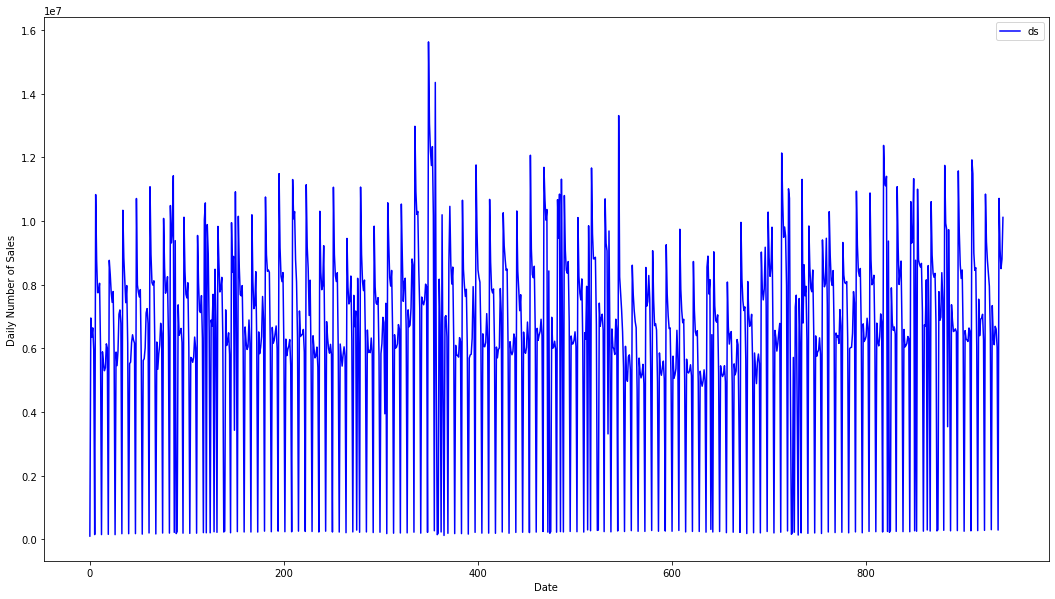

In [48]:
#we plot a graph of sales over the years 
ax = saledata.plot(figsize = (18, 10), color = 'b')
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

We use the power of prophet to model holidays and check for how they affect sales

In [92]:
#create a new dataframe with date and idicator of wheteher the date is a holiday or not
holidaydata=data[['Date','StateHoliday']]

holidaydata.drop_duplicates(inplace=True)
holidaydata

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Date,StateHoliday
0,2015-07-31,0
1115,2015-07-30,0
2230,2015-07-29,0
3345,2015-07-28,0
4460,2015-07-27,0
...,...,...
1011635,2013-01-05,0
1012750,2013-01-04,0
1013865,2013-01-03,0
1014980,2013-01-02,0


For prophet to porccess data we need to have the holidays in sring iterable format

In [95]:
#select only rows that have either of the specified holidays
stateHoliday=data[(data['StateHoliday'] == 'a') | (data['StateHoliday']== 'b') | (data['StateHoliday'] == 'c')].loc[:, 'Date'].values
schoolHoliday=data[data['SchoolHoliday']==1].loc[:, 'Date'].values

stateHoliday=pd.DataFrame({'holiday': 'State Holiday',
                           'ds': pd.to_datetime(stateHoliday)})
schoolHoliday=pd.DataFrame({'holiday': 'schoold_holiday',
                            'ds': pd.to_datetime(schoolHoliday)})

holidays=pd.concat((stateHoliday,schoolHoliday))
holidays.drop_duplicates(inplace=True)
holidays 

,holiday,ds
0,State Holiday,2015-06-04
87,State Holiday,2015-05-25
120,State Holiday,2015-05-14
152,State Holiday,2015-05-01
172,State Holiday,2015-04-06
...,...,...
160151,schoold_holiday,2013-01-05
160262,schoold_holiday,2013-01-04
161295,schoold_holiday,2013-01-03
162329,schoold_holiday,2013-01-02


In [99]:
saledata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      942 non-null    int64 
 1   y       942 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.8+ KB


## Facebook Prophet

In [109]:
logging.debug("Initializing prophet with 90% uncertainity interval ")
print(" ------ Initilizing prophet -----")

prophet=Prophet(interval_width=0.9,holidays=holidays)
logging.debug(" ----- Fitting Model ----- ")
print(" ----- Fitting Model ---- ")
prophet.fit(saledata,verbose=3)
# we wnt to get sales upto 6 weeks in futre hence we do 6*7 to caclualte the number of days prophet need to forescast 
futureSales = prophet.make_future_dataframe(periods = 6*7)


 ------ Initilizing prophet -----
 ----- Fitting Model ---- 


In [110]:
print("Week One Forecast")
futureSales.tail(7)

Week One Forecast


,ds
977,2015-09-05
978,2015-09-06
979,2015-09-07
980,2015-09-08
981,2015-09-09
982,2015-09-10
983,2015-09-11


In [111]:
logging.debug("Predicting future sales")
print(" -------- Predicting Future Sales ---------- ")
forecast=prophet.predict(futureSales)
print("------- Getting data frame ------")
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(7)

 -------- Predicting Future Sales ---------- 
------- Getting data frame ------


,ds,yhat,yhat_lower,yhat_upper
977,2015-09-05,5.776705e+06,3.492836e+06,8.064487e+06
978,2015-09-06,-3.035432e+05,-2.481839e+06,1.923566e+06
979,2015-09-07,7.979189e+06,5.785195e+06,1.025083e+07
980,2015-09-08,6.894486e+06,4.536535e+06,9.147498e+06
981,2015-09-09,6.492534e+06,4.209658e+06,8.931709e+06
982,2015-09-10,6.655934e+06,4.379068e+06,9.093997e+06
983,2015-09-11,6.997014e+06,4.672344e+06,9.353024e+06


The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [112]:
predictedSales = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

In [113]:
predictedSales

,ds,yhat
0,2013-01-01,1.689092e+06
1,2013-01-02,7.288351e+06
2,2013-01-03,7.366890e+06
3,2013-01-04,7.626072e+06
4,2013-01-05,6.612137e+06
...,...,...
979,2015-09-07,7.979189e+06
980,2015-09-08,6.894486e+06
981,2015-09-09,6.492534e+06
982,2015-09-10,6.655934e+06


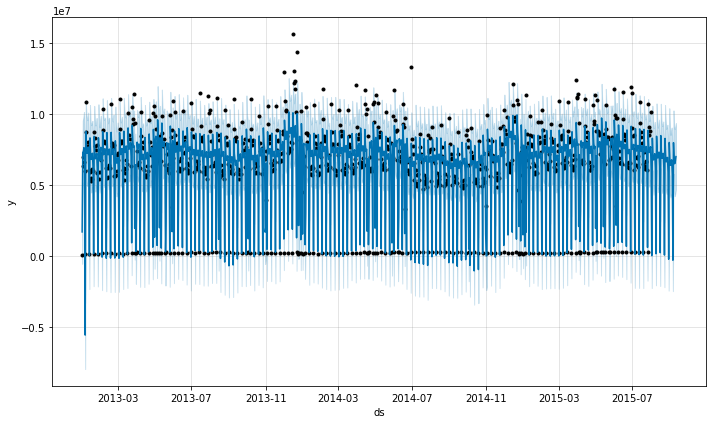

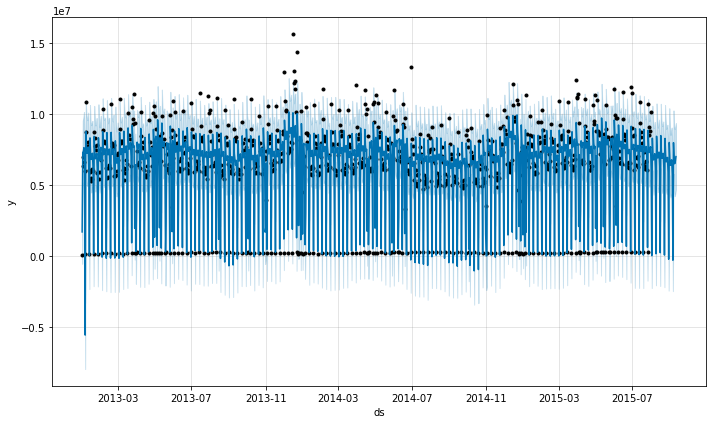

In [114]:
#prophet does a pretty good job of picking up trends 
logging.info(" ------ Prophets forecast ------")
prophet.plot(forecast)

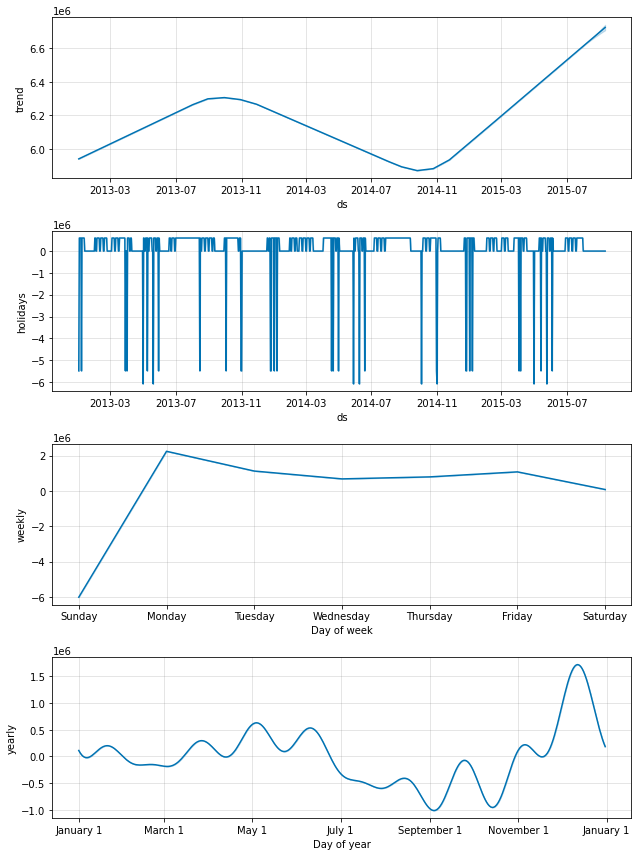

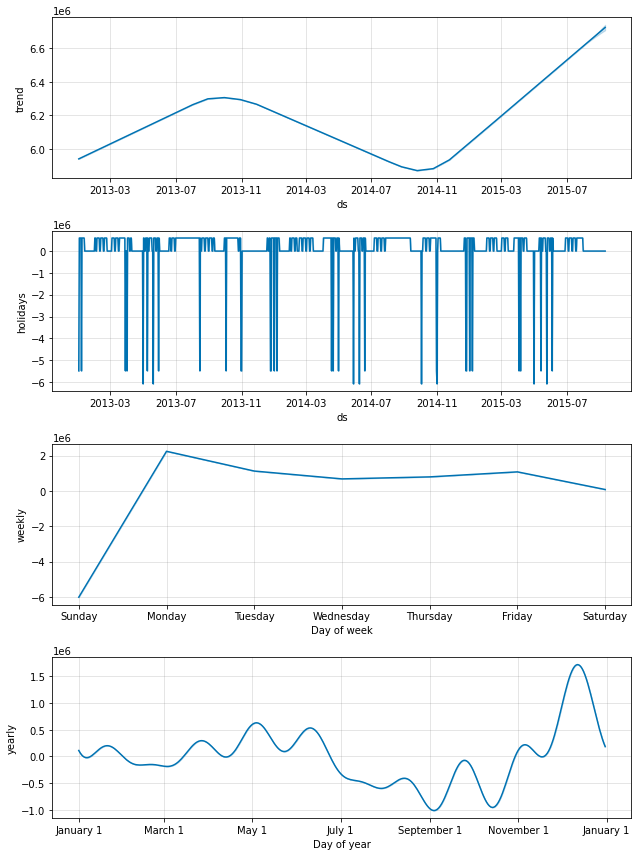

In [115]:
prophet.plot_components(forecast)

## LSTM 

In [116]:
saledata

,y,ds
0,97235,2013-01-01
1,6949829,2013-01-02
2,6347820,2013-01-03
3,6638954,2013-01-04
4,5951593,2013-01-05
...,...,...
937,10707292,2015-07-27
938,9115073,2015-07-28
939,8499962,2015-07-29
940,8798854,2015-07-30


In [118]:

datedata=data.groupby(['Date']).agg({'Sales':sum})
datedata


,Sales
Date,
2013-01-01,97235
2013-01-02,6949829
2013-01-03,6347820
2013-01-04,6638954
2013-01-05,5951593
...,...
2015-07-27,10707292
2015-07-28,9115073
2015-07-29,8499962


In [ ]:
plt.figure(figsize=(40,15))
sns.lineplot(datedata.index, datedata.Sales)
plt.xticks(rotation=70)

In [172]:
#being a deep learning model there is need to scale the data
scaler=MinMaxScaler()
scaler.fit(datedata.Sales.values.reshape([-1, 1]))
Sales_Scaled = scaler.transform(datedata.Sales.values.reshape(-1, 1))
datedata['Sales_Scaled'] = Sales_Scaled


In [173]:
datedata

,Sales,Sales_Scaled
Date,,
2013-01-01,97235,0.000000
2013-01-02,6949829,0.441354
2013-01-03,6347820,0.402580
2013-01-04,6638954,0.421331
2013-01-05,5951593,0.377060
...,...,...
2015-07-27,10707292,0.683360
2015-07-28,9115073,0.580810
2015-07-29,8499962,0.541193


In [174]:
datedata.describe()

,Sales,Sales_Scaled
count,9.420000e+02,942.000000
mean,6.234799e+06,0.395301
std,3.130536e+06,0.201628
min,9.723500e+04,0.000000
25%,5.675832e+06,0.359300
50%,6.580354e+06,0.417557
75%,8.174899e+06,0.520256
max,1.562355e+07,1.000000


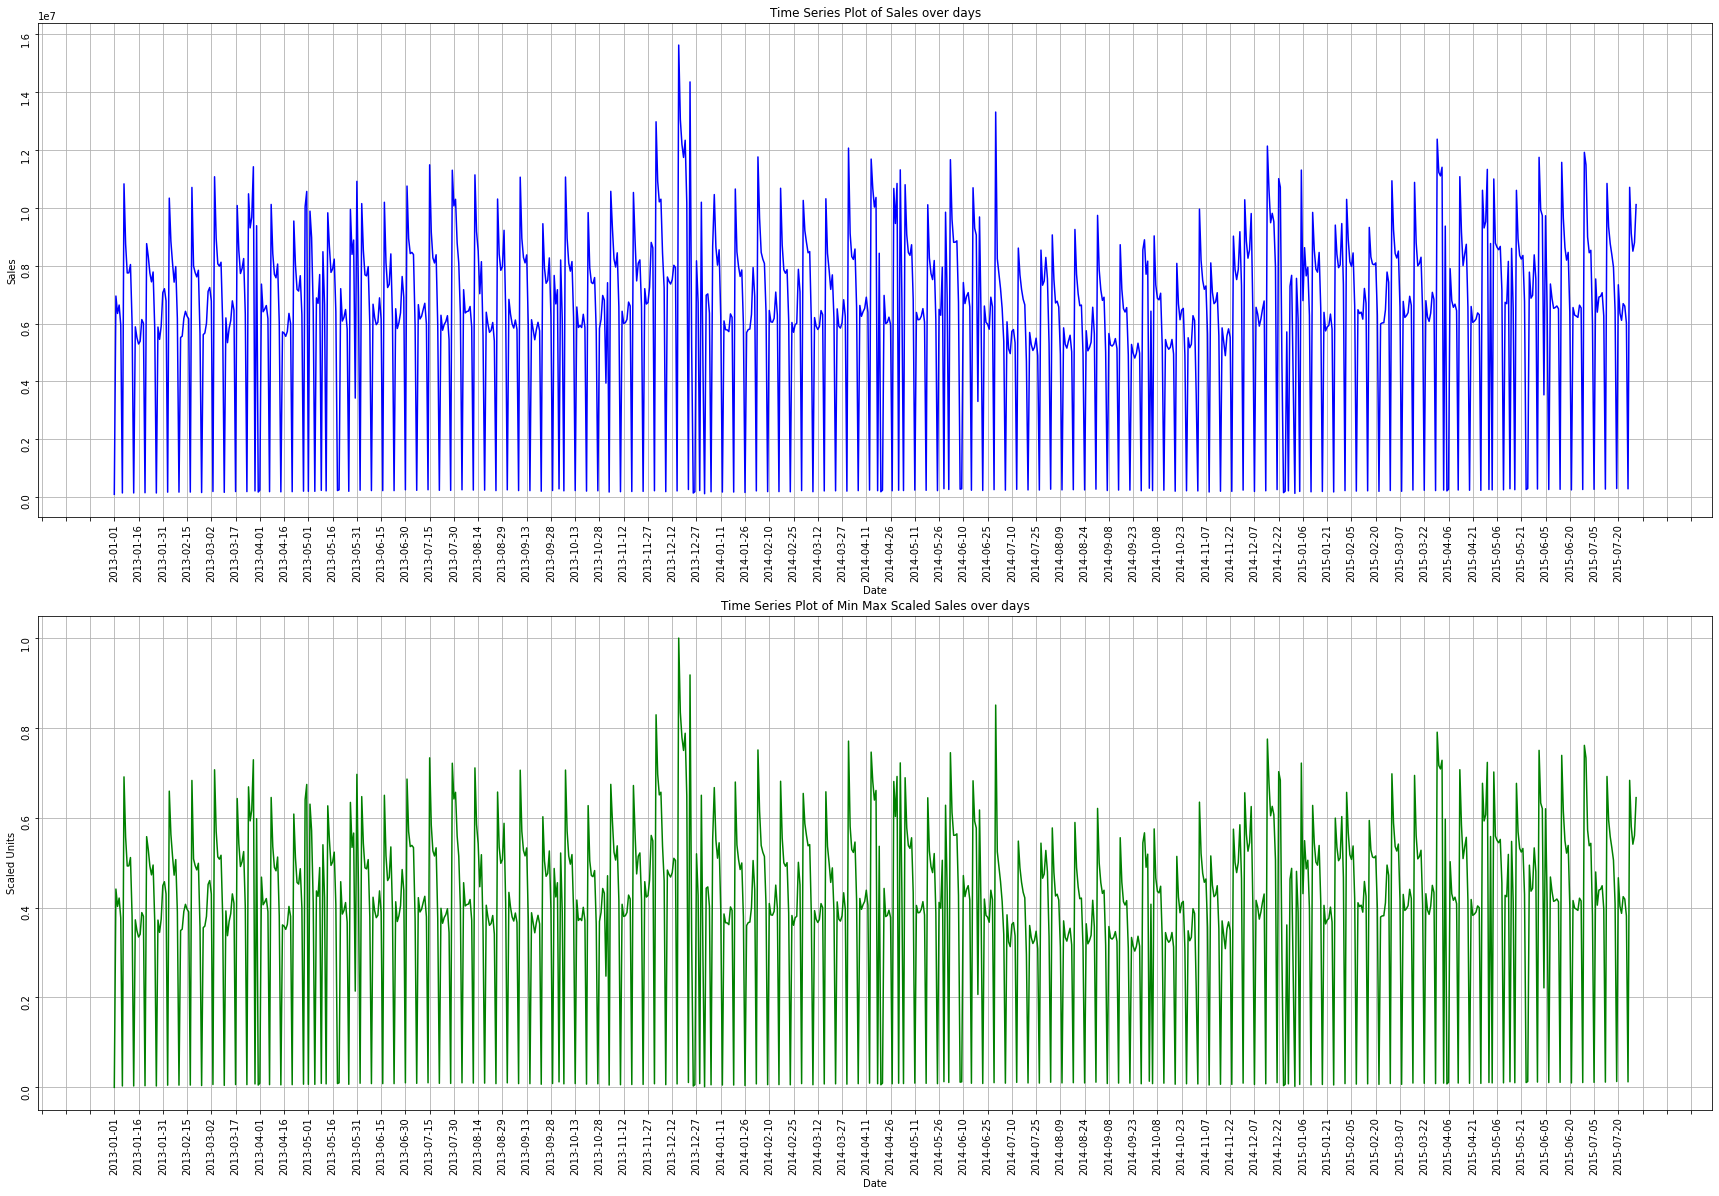

In [175]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(datedata.index, datedata.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales')
ax1.title.set_text('Time Series Plot of Sales over days')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(datedata.index, datedata.Sales_Scaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled Sales over days')
ax2.grid(True)
plt.show()

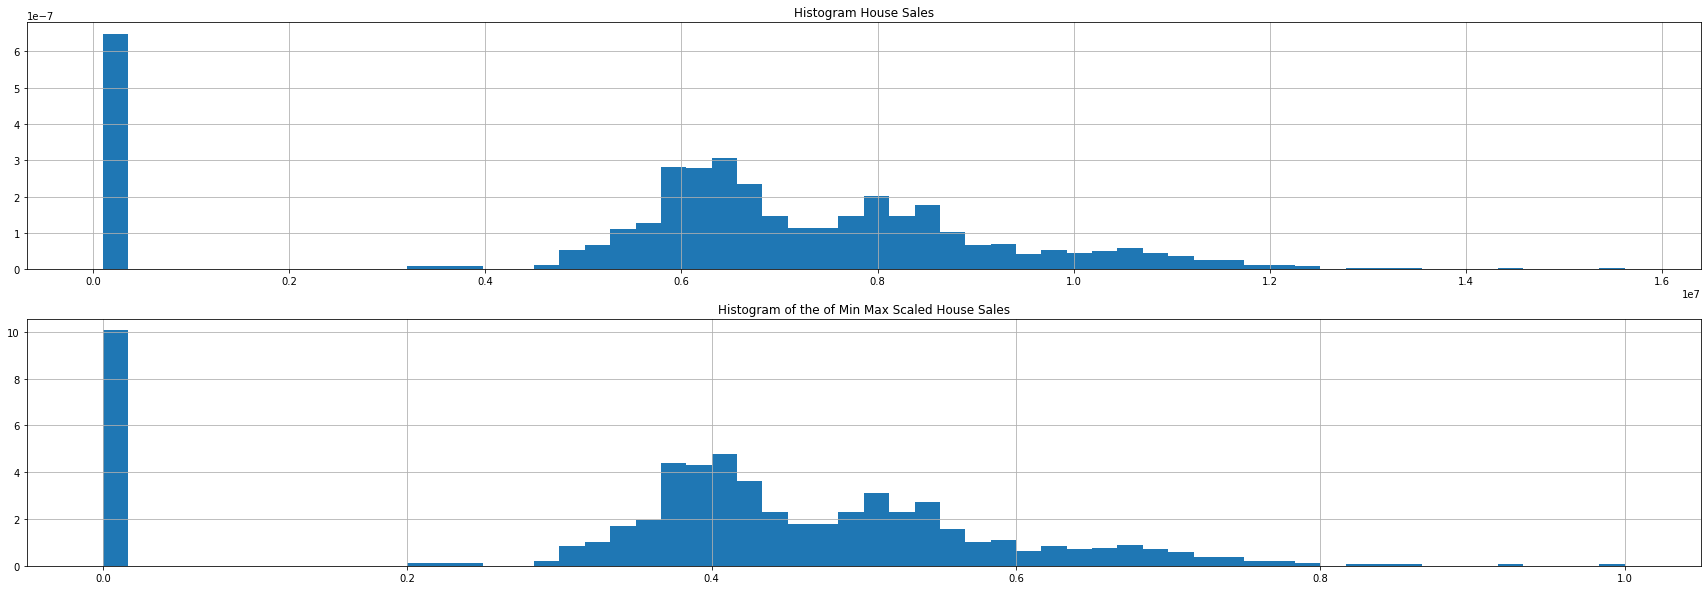

In [176]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(datedata.Sales, density=True, bins=60)
ax1.title.set_text('Histogram House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(datedata.Sales_Scaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()

In [177]:
adfResult = adfuller(datedata.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -4.761614524595616
p-value: 6.436731330559295e-05


Our p-value is higher than 0.5 and hence we can conclude that our data does not potray stationarity 

In [178]:
acfSalesScaled = acf(datedata.Sales_Scaled.values, fft=True, nlags=40)
acfSalesScaledNp = np.array(acfSalesScaled)

In [179]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

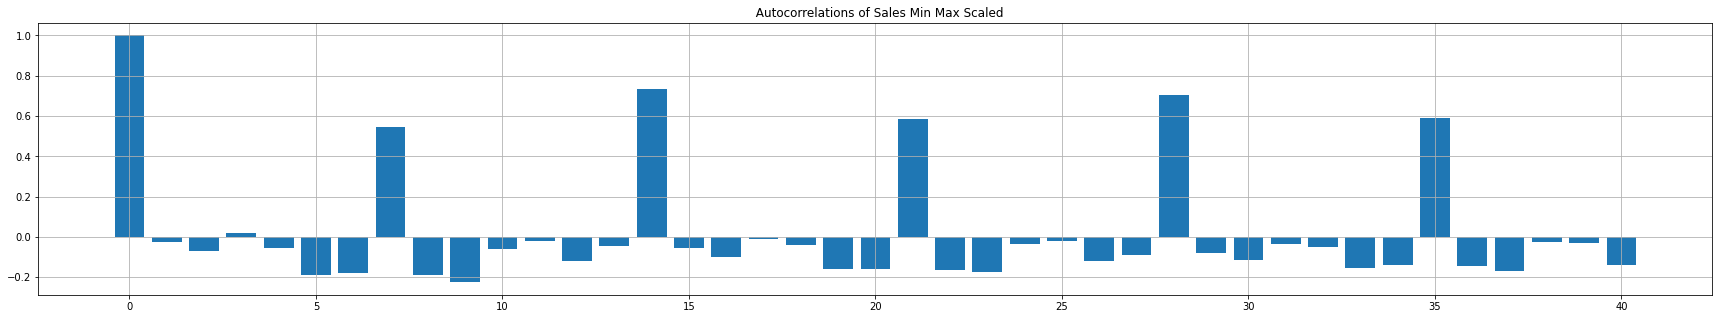

In [130]:
corrPlots(acfSalesScaledNp, '')

The data seems to be going down an up 

In [180]:
pacfSalesScaled = pacf(datedata['Sales_Scaled'].values, nlags=40)
pacfSalesScaledNp = np.array(pacfSalesScaled)

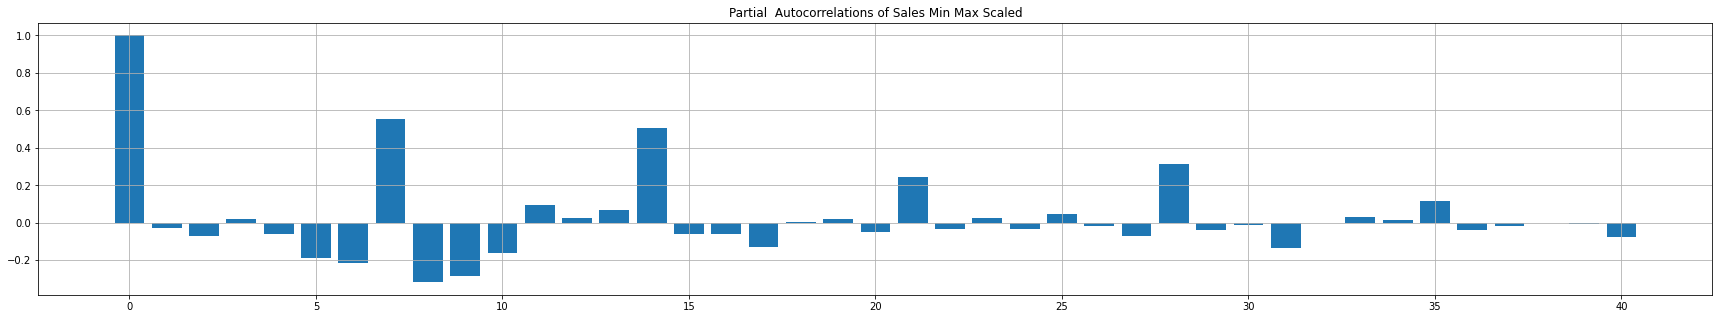

In [181]:
corrPlots(pacfSalesScaledNp, "Partial")

In [182]:
SIZE = len(datedata['Sales_Scaled'])
WINDOW_SIZE = 48
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 200

In [183]:
DateTrain = datedata.index.values[0:BATCH_SIZE]
DateValid = datedata.index.values[BATCH_SIZE:]
XTrain = datedata['Sales_Scaled'].values[0:BATCH_SIZE].astype('float32')
XValid = datedata['Sales_Scaled'].values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (846, 1)
Shape of the validation set date series:  (96, 1)

Shape of the training set logarithm of sales series:  (846,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (96,)


In [184]:
tf.random.set_seed(1234)
# add extra dimension
series = tf.expand_dims(XTrain, axis=-1)
series.shape

TensorShape([846, 1])

In [185]:
# create tensor from each individual element
dataset = tf.data.Dataset.from_tensor_slices(series)
dataset

<TensorSliceDataset shapes: (1,), types: tf.float32>

In [186]:
# takes a window_size + 1 chunk from the slices
dataset = dataset.window(WINDOW_SIZE + 1, shift=1, drop_remainder=True) 

In [142]:
dataset = dataset.flat_map(lambda window: window.batch(WINDOW_SIZE + 1))

In [187]:
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

TypeError: ignored

In [188]:
dataset = dataset.batch(BATCH_SIZE).prefetch(1)

In [189]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [190]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [191]:
model = Sequential()
model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
model.add(LSTM(4, input_shape=[None, 1]))
model.add(Dense(1))
model.compile(loss="huber_loss", optimizer='adam')

In [192]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 8)           320       
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [193]:
history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=1)

Epoch 1/200
1/1 [==============================] - 5s 5s/step - loss: 0.1526 - val_loss: 0.1735
Epoch 2/200
1/1 [==============================] - 0s 201ms/step - loss: 0.1475 - val_loss: 0.1680
Epoch 3/200
1/1 [==============================] - 0s 201ms/step - loss: 0.1426 - val_loss: 0.1626
Epoch 4/200
1/1 [==============================] - 0s 205ms/step - loss: 0.1378 - val_loss: 0.1574
Epoch 5/200
1/1 [==============================] - 0s 206ms/step - loss: 0.1332 - val_loss: 0.1523
Epoch 6/200
1/1 [==============================] - 0s 195ms/step - loss: 0.1288 - val_loss: 0.1475
Epoch 7/200
1/1 [==============================] - 0s 195ms/step - loss: 0.1245 - val_loss: 0.1427
Epoch 8/200
1/1 [==============================] - 0s 205ms/step - loss: 0.1203 - val_loss: 0.1382
Epoch 9/200
1/1 [==============================] - 0s 199ms/step - loss: 0.1163 - val_loss: 0.1338
Epoch 10/200
1/1 [==============================] - 0s 204ms/step - loss: 0.1124 - val_loss: 0.1295
Epoch 11/200

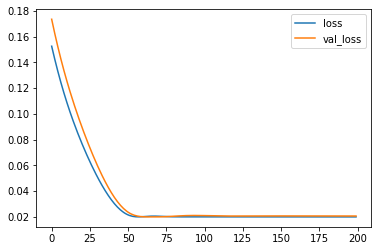

In [194]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [195]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [196]:
Forecast = model_forecast(model, datedata.Sales_Scaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

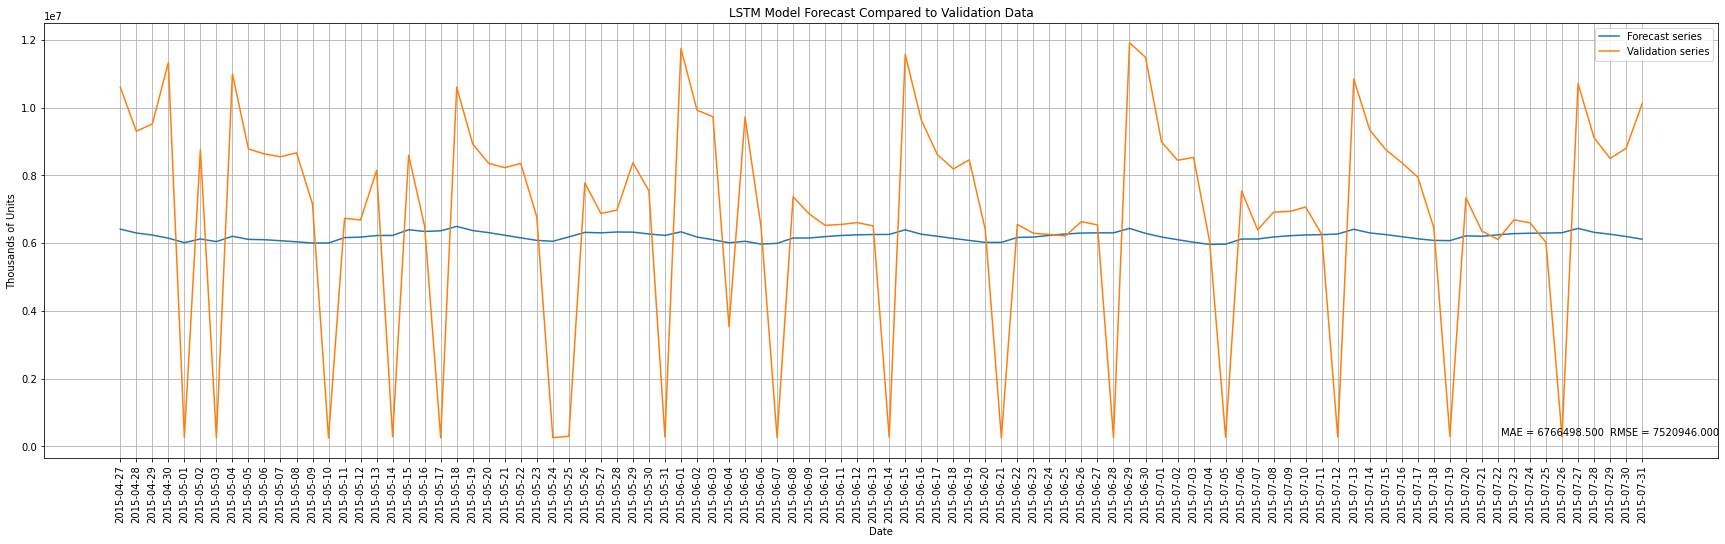

In [197]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [198]:
print(textstr)

MAE = 6766498.500  RMSE = 7520946.000
